In [1]:
import pandas as pd
from typing import Literal
import yfinance as yf
import itertools
import matplotlib.pyplot as plt

In [2]:
sector_dict = {
    'Consumer Discretionary' : '^YH102', 
    'Basic Materials' : '^YH101', 
    'Industrials' : '^YH310',
    'Financials' : '^YH103', 
    'Technology' : '^YH311', 
    'Consumer Staples' : '^YH205', 
    'Utilities' : '^YH207',
    'Health Care' : '^YH206', 
    'Telecommunications' : '^YH308',
    'Energy' : '^YH309', 
    'Real Estate' : '^YH104'
}
market_ticker = '^GSPC'
riskfree_ticker = '^TNX'
start = '2020-01-01'
end = '2025-01-01'

In [3]:
def beta(asset: pd.Series, market: pd.Series, way: Literal['+', '-', 'all']):
    """
    Description:
    Beta is a measure of a financial instrument's sensitivity to market movements. A beta of 1 indicates the asset tends
    to move in line with the market, a beta greater than 1 suggests higher volatility, and a beta less than 1 indicates
    lower volatility compared to the market.

    Parameters:
    - asset (pd.Series): Time series data representing the returns of the asset.
    - market (pd.Series): Time series data representing the returns of the market.
    - way (Literal['+', '-', 'all']): Specifies which type of data points should be considered for the beta calculation:
        - '+' (positive): Only considers periods where the asset's returns are positive. This is useful for measuring
          the beta when the asset is performing well.
        - '-' (negative): Only considers periods where the asset's returns are negative. This is useful for measuring
          the beta when the asset is underperforming.
        - 'all': Considers all periods without any filtering, giving the traditional beta measurement.

    Returns:
    - float: Beta coefficient, which measures the asset's sensitivity to market movements based on the specified filter.
    """
    df = pd.concat([asset, market], axis=1).dropna().pct_change().dropna()

    if way == '+':
        df = df[df.iloc[:, 0] > 0] 
    elif way == '-':
        df = df[df.iloc[:, 0] < 0]
    elif way == 'all':
        pass

    covariance = df.cov().iloc[1, 0]
    market_variance = df.iloc[:, 1].var()
    return covariance / market_variance

def alpha_jensen(asset, market, riskfree):
    """
    Description:
    Jensen's alpha is a risk-adjusted performance metric that represents the excess return of an asset over its expected
    return, given its beta and the expected return of the market. It is calculated as the difference between the actual
    return and the expected return based on the Capital Asset Pricing Model (CAPM).

    Parameters:
    - asset (pd.Series): Time series data representing the returns of the asset.
    - market (pd.Series): Time series data representing the returns of the market.
    - riskfree (float): Risk-free rate of return, typically the yield of a government bond.

    Returns:
    - float: Jensen's alpha, which measures the excess return of the asset over its expected return.
    """

    asset_beta = beta(asset, market, 'all')
    asset_return = asset.iloc[-1] / asset.iloc[0] - 1
    market_return = market.iloc[-1] / market.iloc[0] - 1
    risk_free_return = (1+riskfree)**(len(asset)/252) - 1

    return asset_return - (risk_free_return + asset_beta * (market_return - risk_free_return))


In [4]:
history_df = pd.DataFrame()
history_df['Market'] = yf.download(market_ticker, start=start, end=end)['Close'][market_ticker]
history_df['RiskFree'] = yf.download(riskfree_ticker, start=start, end=end)['Close'][riskfree_ticker]
for sector, ticker in sector_dict.items():
    history_df[sector] = yf.download(ticker, start=start, end=end)['Close'][ticker]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


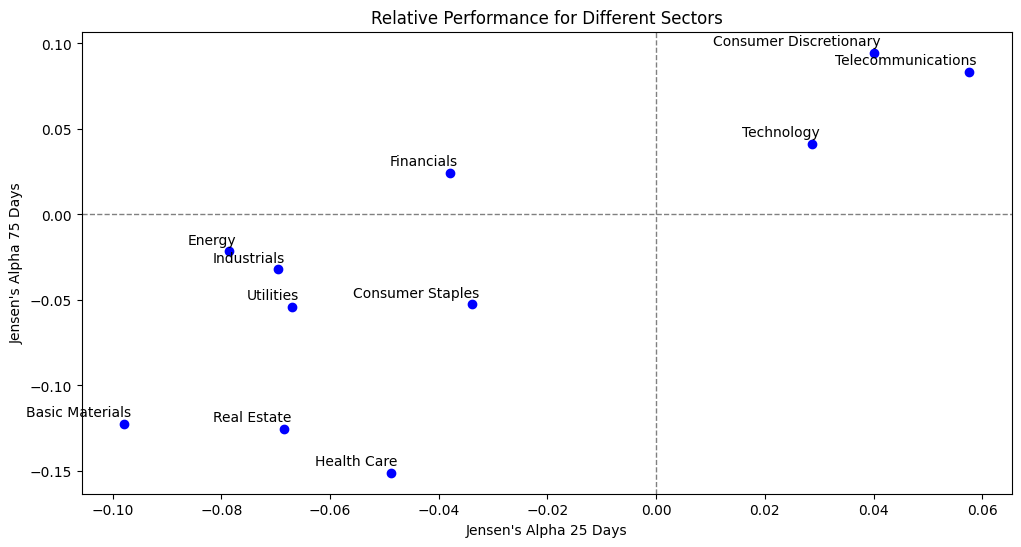

In [5]:
windows = [25, 75]

jensen_alpha_df = pd.DataFrame()
for sector, window in itertools.product(sector_dict.keys(), windows):
    jensen_alpha_df.at[sector, window] = alpha_jensen(history_df[sector].iloc[-window:], history_df['Market'].iloc[-window:], history_df['RiskFree'].iloc[-1]/100)

fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(jensen_alpha_df[min(windows)], jensen_alpha_df[max(windows)], label='Sectors', color='blue')
for sector in jensen_alpha_df.index:
    ax.annotate(sector, (jensen_alpha_df[min(windows)][sector], jensen_alpha_df[max(windows)][sector]), textcoords="offset points", xytext=(5,5), ha='right')
ax.axhline(0, linestyle="--", color="grey", linewidth=1)
ax.axvline(0, linestyle="--", color="grey", linewidth=1)
plt.title("Relative Performance for Different Sectors")
plt.xlabel(f"Jensen's Alpha {min(windows)} Days")
plt.ylabel(f"Jensen's Alpha {max(windows)} Days")
plt.show()

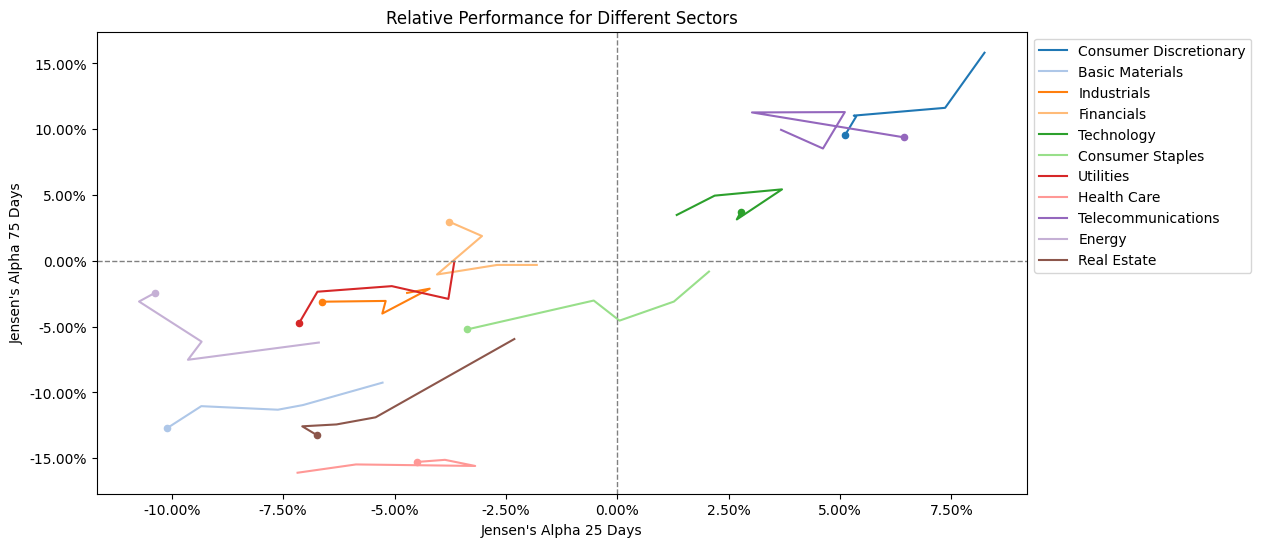

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import matplotlib.ticker as mticker

windows = [25, 75]
lookback_steps = np.arange(1, 10, 2)
sectors = list(sector_dict.keys())
sector_colors = {s: plt.get_cmap("tab20")(i % 20) for i, s in enumerate(sectors)}

# Calcul du Jensen's Alpha
jensen_alpha_df = {lookback: pd.DataFrame(index=sectors, columns=windows) for lookback in lookback_steps}

for sector, window, lookback in product(sectors, windows, lookback_steps):
    jensen_alpha_df[lookback].at[sector, window] = alpha_jensen(
        history_df[sector].iloc[-window-lookback:-lookback],
        history_df['Market'].iloc[-window-lookback:-lookback],
        history_df['RiskFree'].iloc[-lookback-1] / 100
    )*100

# Tracé du graphique
fig, ax = plt.subplots(figsize=(12, 6))

for sector in sectors:
    x_vals = [jensen_alpha_df[lb][min(windows)][sector] for lb in lookback_steps]
    y_vals = [jensen_alpha_df[lb][max(windows)][sector] for lb in lookback_steps]
    color = sector_colors[sector]
    
    ax.plot(x_vals, y_vals, color=color, linewidth=1.5, label=sector)
    
    ax.scatter(x_vals[0], y_vals[0], color=color, marker="o", s=20)

ax.axhline(0, linestyle="--", color="grey", linewidth=1)
ax.axvline(0, linestyle="--", color="grey", linewidth=1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Relative Performance for Different Sectors")
plt.xlabel(f"Jensen's Alpha {min(windows)} Days")
plt.ylabel(f"Jensen's Alpha {max(windows)} Days")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f%%"))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f%%"))
plt.show()


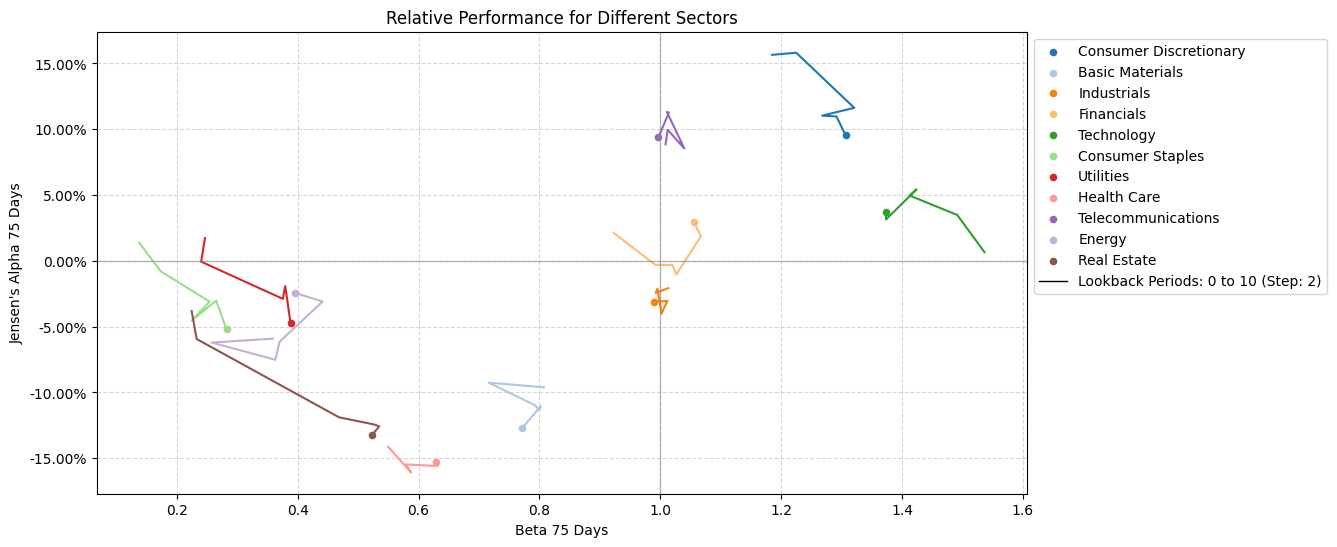

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Définition des paramètres
window_alpha = 75
window_beta = 75
lookback_steps = np.arange(1, 12, 2)
sectors = list(sector_dict.keys())
sector_colors = {s: plt.get_cmap("tab20")(i % 20) for i, s in enumerate(sectors)}

# Création des DataFrames pour Jensen's Alpha et Beta
alpha_df = pd.DataFrame(index=sectors, columns=lookback_steps)
beta_df = pd.DataFrame(index=sectors, columns=lookback_steps)

for sector in sectors:
    for lookback in lookback_steps:
        hist_sector_alpha = history_df[sector].iloc[-window_alpha - lookback:-lookback]
        hist_sector_beta = history_df[sector].iloc[-window_beta - lookback:-lookback]
        hist_market_alpha = history_df['Market'].iloc[-window_alpha - lookback:-lookback]
        hist_market_beta = history_df['Market'].iloc[-window_beta - lookback:-lookback]
        risk_free = history_df['RiskFree'].iloc[-lookback - 1] / 100
        
        alpha_df.at[sector, lookback] = alpha_jensen(hist_sector_alpha, hist_market_alpha, risk_free) * 100
        beta_df.at[sector, lookback] = beta(hist_sector_beta, hist_market_beta, way='all')

# Tracé du graphique
fig, ax = plt.subplots(figsize=(12, 6))

scatter_handles = []
for sector in sectors:
    y_vals = alpha_df.loc[sector, :].values.astype(float)
    x_vals = beta_df.loc[sector, :].values.astype(float)
    color = sector_colors[sector]
    
    ax.plot(x_vals, y_vals, color=color, linewidth=1.5)
    scatter = ax.scatter(x_vals[0], y_vals[0], color=color, marker="o", s=20)
    scatter_handles.append((scatter, sector))

ax.axhline(0, color="grey", linewidth=1, alpha=0.5)
ax.axvline(1, color="grey", linewidth=1, alpha=0.5)

# Ajout d'une légende avec points au lieu de lignes
handles, labels = zip(*scatter_handles)

# Ajout d'une ligne noire pour la description des lookbacks
lookback_label = f"Lookback Periods: {lookback_steps[0]-1} to {lookback_steps[-1]-1} (Step: {int((lookback_steps.max()+1)/len(lookback_steps))})"
handles += (plt.Line2D([0], [0], color='black', lw=1),)
labels += (lookback_label,)

ax.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.title("Relative Performance for Different Sectors")
plt.ylabel(f"Jensen's Alpha {window_alpha} Days")
plt.xlabel(f"Beta {window_beta} Days")
plt.grid(True, alpha=0.5, linestyle="--")
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f%%"))
plt.show()
